# Primer uporabe vizualizacije za tabelarične podatke
V tem zvezku demonstriramo delovanje metode za raziskovanje poljubnih projekcij tabelaričnih podatkov.

In [1]:
import sys 
sys.path.append('..')

from lib.tab_exploration.tab_explorer import TabExplorer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(1)
%matplotlib inline

Za demonstracijo uporabimo podatke o ljudeh s titanika. Množica vsebuje zvezne in diskretne atribute. Izbrali smo nasldenjo podmnožico atributov: (spol, starost, cena vstopnice, pristanišče vkrcanja, razred vozovnice ).

In [2]:
df = pd.read_csv('../data/titanic.csv')
df = (df.drop(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
        .dropna(axis=0)
        .astype({'Pclass': object, 'Age': np.int32, 'Fare': np.float32}))
df.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22,7.250000,S
1,1,female,38,71.283302,C
2,3,female,26,7.925000,S
3,1,female,35,53.099998,S
4,3,male,35,8.050000,S


Naslednjo funkcijo uporabimo za standardizacijo zveznih atributov

In [3]:
def standardize_continuous(df):
    df_numeric = df.select_dtypes(include=[np.number])
    df_other =  df.select_dtypes(exclude=[np.number])
    
    df_numeric = (df_numeric - df_numeric.mean())/df_numeric.std()
    return pd.concat([df_numeric, df_other], axis=1)

Za projekcijo podatkov uporabimo t-SNE, za razvrščanje pa DBSCAN.

In [4]:
tsne = TSNE()
dbscan = DBSCAN(eps=1.0)

X = pd.get_dummies(standardize_continuous(df)).values.astype(np.float32)
X_em = tsne.fit_transform(X)
clusters = dbscan.fit_predict(X)

Pridobljeno projekcijo in skupine lahko nato raziščemo.

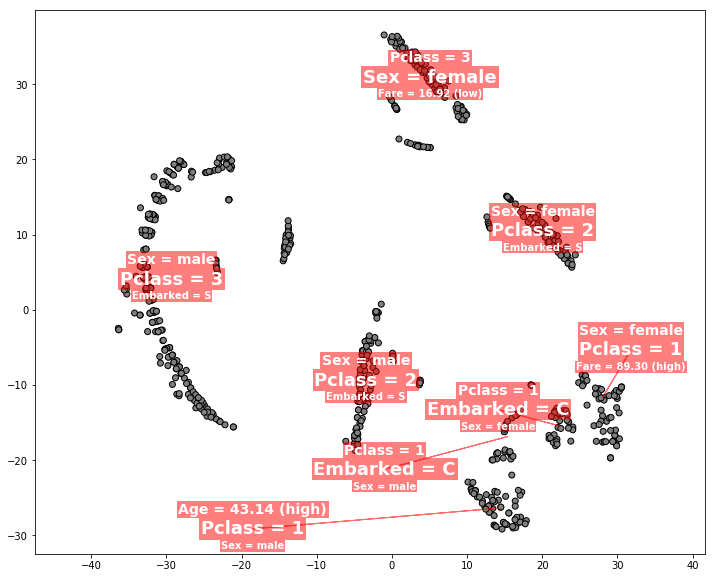

In [5]:
tab_explorer = TabExplorer(p_threshold=1e-2, min_cluster_size=30)
tab_explorer.fit(df, X_em, clusters)
fig, ax = tab_explorer.plot_static(avoid_overlaps=True)

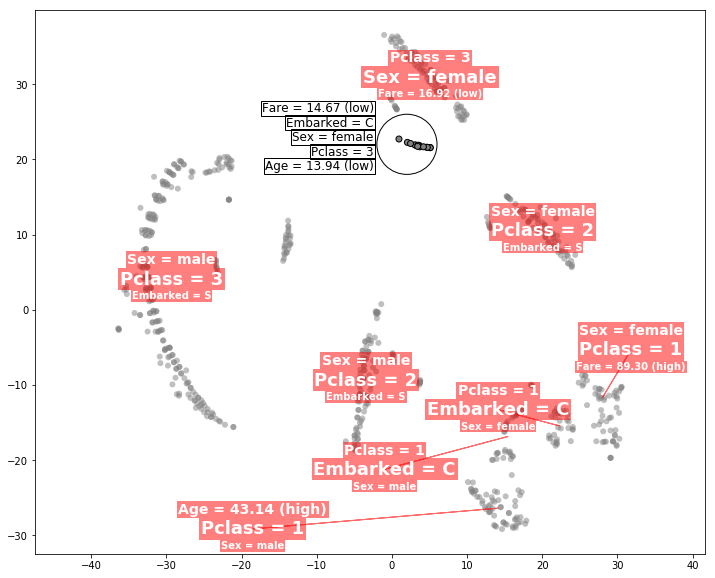

In [6]:
fig, ax = tab_explorer.plot_dynamic(2, 22, 4)
fig

<IPython.core.display.Javascript object>


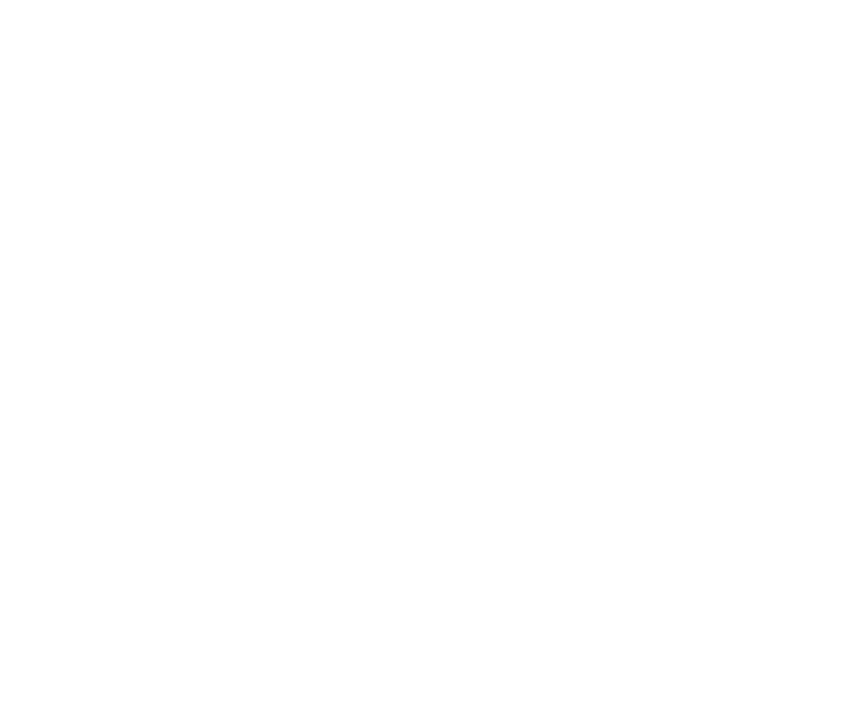

<IPython.core.display.Javascript object>


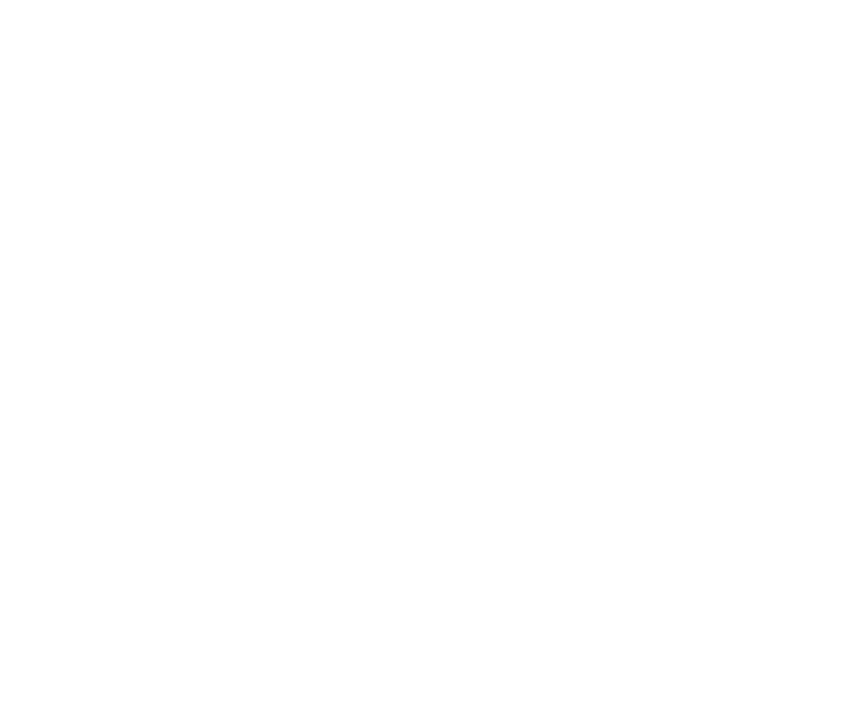

In [7]:
%matplotlib notebook

tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)
fig, ax = tab_explorer.plot_interactive()

Primer izračuna p-vrednosti za prvo (oranžno) skupino.

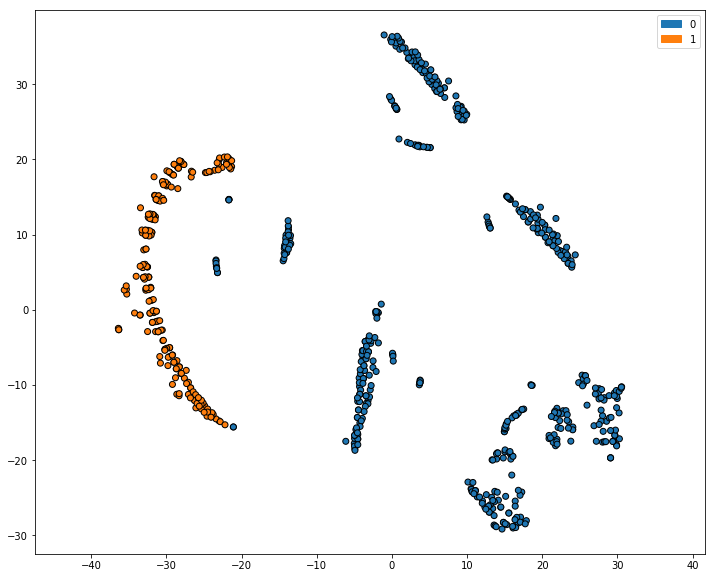

In [8]:
%matplotlib inline
is_first_cluster = clusters==0
fig,ax = tab_explorer.plot_static(classes=is_first_cluster.astype(np.int), plot_labels=False)

Najprej prodobimo nekaj osnovnih informacij o skupini.

In [9]:
df_dummies = pd.concat([pd.get_dummies(df[col]) if df[col].dtype==object else df[col] for col in df], axis=1,
                                     keys=df.columns)
first_cluster = df_dummies.loc[is_first_cluster]
not_first_cluster = df_dummies.loc[~is_first_cluster]


print("Total dataset size: {}".format(df_dummies.shape[0])) 
print("Cluster size: {}".format(first_cluster.shape[0])) 
print("Out-cluster size: {}".format(not_first_cluster.shape[0])) 

Total dataset size: 712
Cluster size: 214
Out-cluster size: 498


Za računanje p-vrednosti so ključne porazdelitve vrednosti v skupini, izven nje ter globalne porazdelitve.

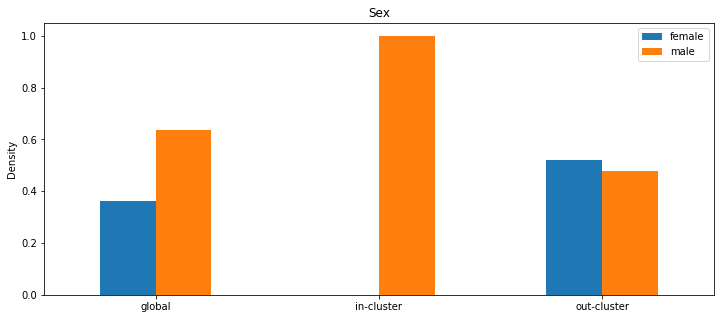

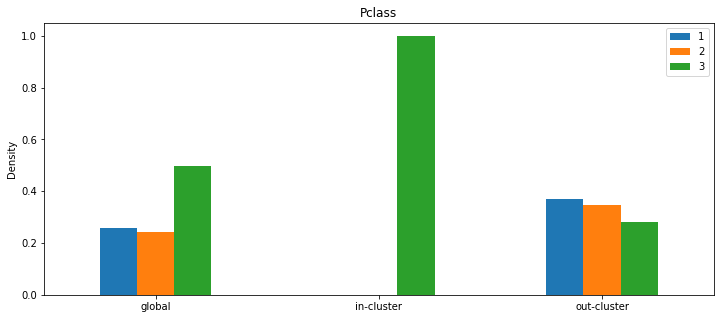

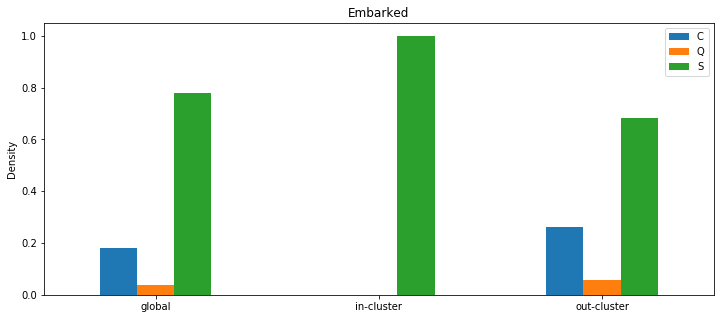

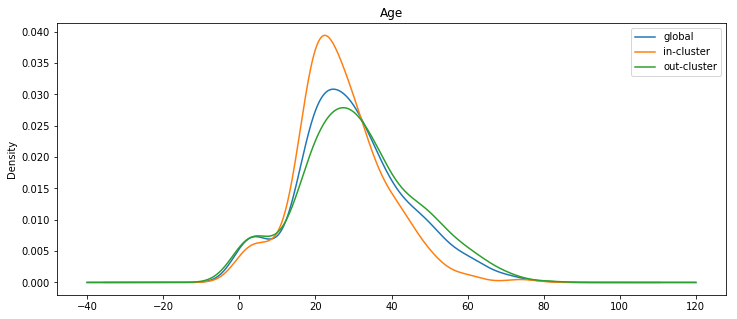

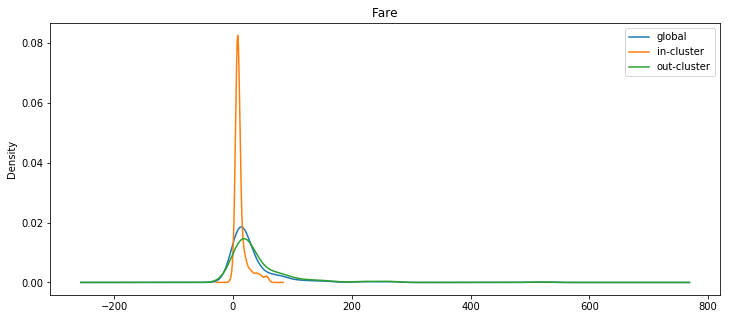

In [10]:
keys = ['global', 'in-cluster', 'out-cluster']
dfs = [df_dummies, first_cluster, not_first_cluster]

for c in set(df_dummies.columns.get_level_values(0)):
    if np.issubdtype(df[c].dtype, np.number):
        kind = 'kde'
        plot_df = pd.concat([df[c] for df in dfs], axis=1, keys=keys).T.reset_index(drop=True).T
        plot_df.columns = keys
    else:
        kind = 'bar'
        plot_df = pd.DataFrame([df[c].sum()/df[c].shape[0] for df in dfs],
                          index=keys)
    
    ax = plot_df.plot(kind=kind, rot=0, figsize=(12,5), title=c)
    ax.set_ylabel('Density')
    plt.show()

Opazimo, da so na teh podatkih porazdelitve v skupini precej čiste, sploh za diskretne atribute kjer imajo vsi pripadniki skupine enake vrednosti. Čiste porazdelitve dobimo tudi za veliko večino ostalih skupin, saj so podatki precej preprosti.

(TODO: razumljivo, saj je vpliv diskretnih spremenljivk na t-SNE in clustering precejšen - zaradi uporabljene razdalje in kodiranja diskretnih spremenljivk).

Če prikažemo še izračune p-vrednosti, opazimo da so te v skladu z našimi ugotovitvami. Poleg očitnih vrednosti za diskretne spremenljivke opazimo, da ima starost precej višjo p-vrednost od cene vozovnice. Tudi to je skladno z zgornjimi slikami saj je porazdelitev cene vozovnic v skupini precej bolj drugačna od te izven skupine (v primerjavi s starostjo).

In [11]:
numeric_p_values = tab_explorer._numeric_p_values(is_first_cluster)
discrete_p_values, discrete_min_p_values = tab_explorer._discrete_p_values(is_first_cluster)

p_values = pd.concat([numeric_p_values, discrete_p_values])
p_values

Age              3.922441e-05
Fare             6.619511e-27
(Pclass, 1)      1.000000e+00
(Pclass, 2)      1.000000e+00
(Pclass, 3)      4.659873e-86
(Sex, female)    1.000000e+00
(Sex, male)      1.233160e-53
(Embarked, C)    1.000000e+00
(Embarked, Q)    1.000000e+00
(Embarked, S)    3.050745e-29
dtype: float64

Multiple comparisons problem empirical evaluation.

In [12]:
X = np.random.uniform(size=(1000,150))
clusters = np.random.randint(0,4, size=(1000,))
X_em = np.random.uniform(size=(1000, 2))
df = pd.DataFrame(X)
df['discrete'] = np.random.randint(0,4, size=(1000,)).astype(object)

(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f967a143588>)

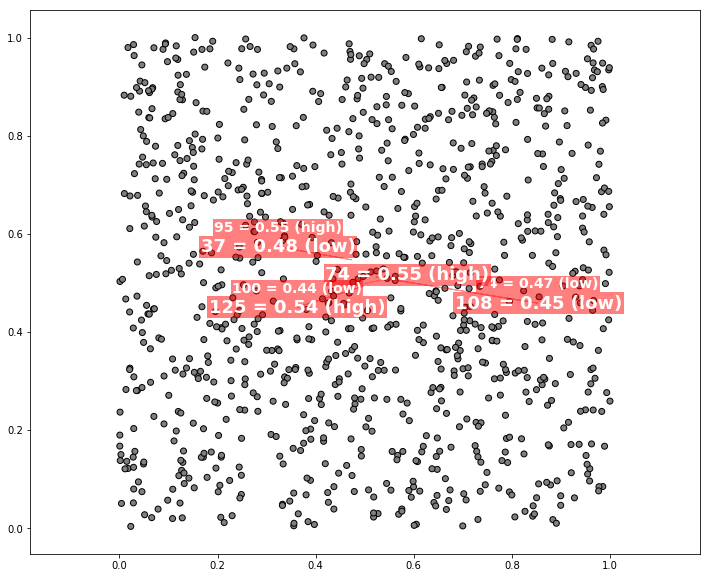

In [13]:
tab_explorer = TabExplorer(p_threshold=0.01)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)